# The Pipeline

1. Question & required data
2. Acquire the data
3. Data Analysis
4. Prepare the data for the Deep Learning Model
5. Building & training the model
6. Testing the model
7. Interpreting the model
8. Improving the model

# Problem introduction: predicting whether a bank customer will leave the bank

## Question & required data

The dataset consists of a bunch of features describing the customers of a bank. The question that is posed is that, given these features could we detect some patterns that allow us to predict if a customer is about to leave a bank?

It would then be possible to direct marketing efforts to the customers if it would be beneficial to retain them.

### ML problem characteristics

1. Task: **classification**
2. Attribute Types: **Categorical, continuous and binary**
3. **14** attributes
4. **10k** instances
5. ML model: **Deep neural net**
6. Deep learning library: **Keras (Tensorflow)**
7. Hyperparameter tuning: **Talos**

#### The feature vector

1. *RowNumber* 
2. *CustomerId:* unique id to identify a customer
3. *Surname*
4. *CreditScore:* a creditscore compiled by the bank for each customer
5. *Geography*
6. *Gender*
7. *Age*
8. *Tenure:* how long has the customer been with the bank
9. *Balance*
10. *NumOfProducts:* how many products of the bank (credit/debit cards etc.) does the customer have
11. *HasCrCard:* does the customer have a credit card
12. *IsActiveMember:* is the customer an active member of the bank
13. *EstimatedSalary:* the customer's estimated salary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dropout, Dense
import talos

sns.set()
tf.__version__

Using TensorFlow backend.


'2.0.0'

In [2]:
data = pd.read_csv('dataset/exit_prediction.csv')
print('Our dataset holds {} records and {} attributes'.format(*data.shape))
data.head()

Our dataset holds 10000 records and 14 attributes


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


*RowNumber*, *CustomerId* & *Surname* won't actually be useful for the deep learning model that we will build in the end so we can just go ahead and drop them.

In [3]:
data.drop(labels=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

## Data Analysis

1. [Tidy](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html) Data: by default
2. **Acquaintance with the data**
3. Outliers
4. Missing Data
5. Class-Imbalance problem
6. Feature correlation

### Acquaintance with the data

Lets visualize a subset of the feature vector for this purpose

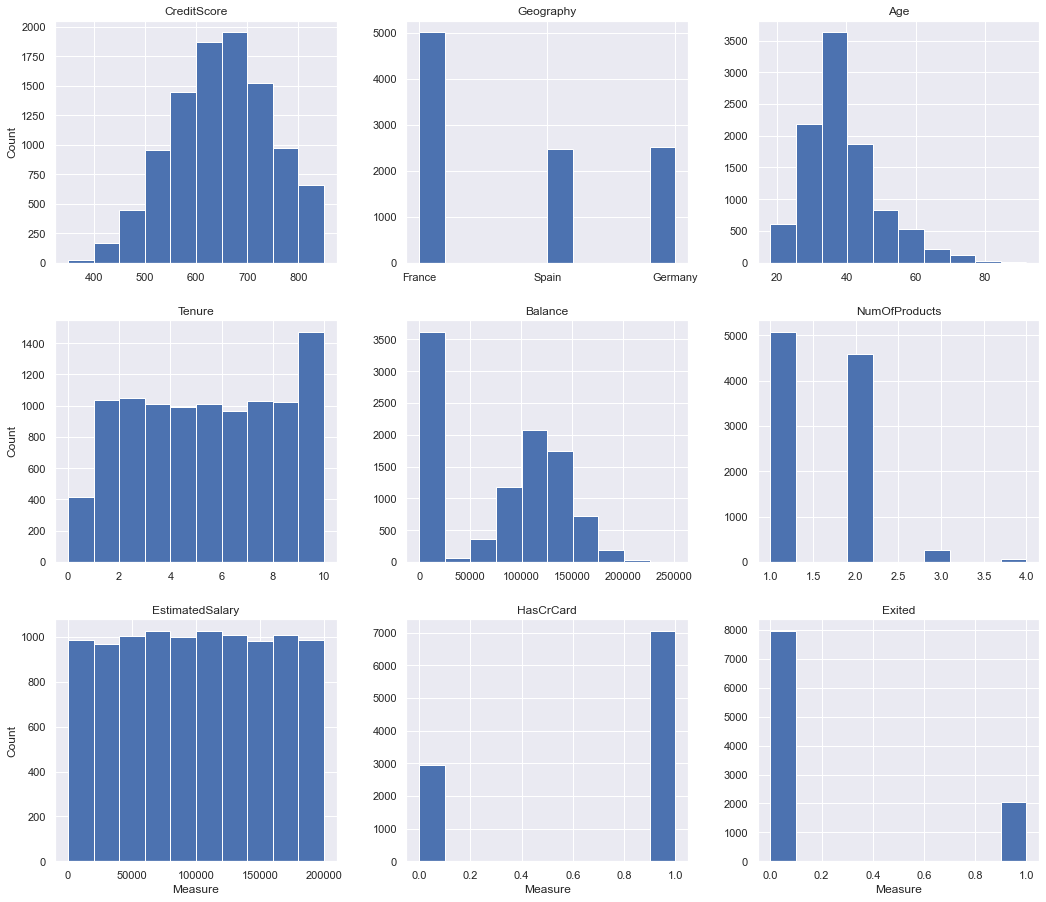

In [4]:
plt.figure(figsize=(15,13))
selected_features = data[['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                                                                      'EstimatedSalary', 'HasCrCard', 'Exited']]

for i in range(1, selected_features.shape[1]+1):
    plt.subplot(3,3,i)
    figure=plt.gca()
    figure.set_title(selected_features.columns[i-1])
    
    plt.hist(selected_features.iloc[:, i-1])
    if selected_features.columns[i-1] in ['EstimatedSalary', 'HasCrCard', 'Exited']:
        plt.xlabel('Measure')
    if selected_features.columns[i-1] in ['CreditScore', 'Tenure', 'EstimatedSalary']:
        plt.ylabel('Count')
    
plt.tight_layout(pad=2)

### Outliers

It appears that we have no outliers. This observation is also confirmed by the above plot

In [5]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### Missing Data

Our dataset seems to have no missing values. We cannot call the values of the *Balance = 0* as missing values since this can be a value that the balance can indeed take.

For an approach of taking care of missing values see the other project on Autism Predictor

In [6]:
print('Does our dataset contain missing values?', data.isnull().any().any())

Does our dataset contain missing values? False


### Class-Imbalance problem

Our data seems indeed to have imbalanced classes. Obviously, most of the people did not leave the bank.

0    0.7963
1    0.2037
Name: Exited, dtype: float64


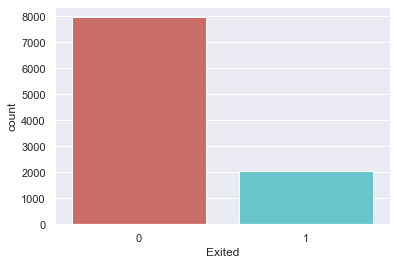

In [7]:
print(data['Exited'].value_counts()/data.shape[0])

sns.countplot(x='Exited', data=data, palette='hls'); plt.show()

**Are the classes well separated?**

If our classes are well separated, then the class-imbalance problem is not really a problem. We can simply visualize a couple of the attributes for this purpose.

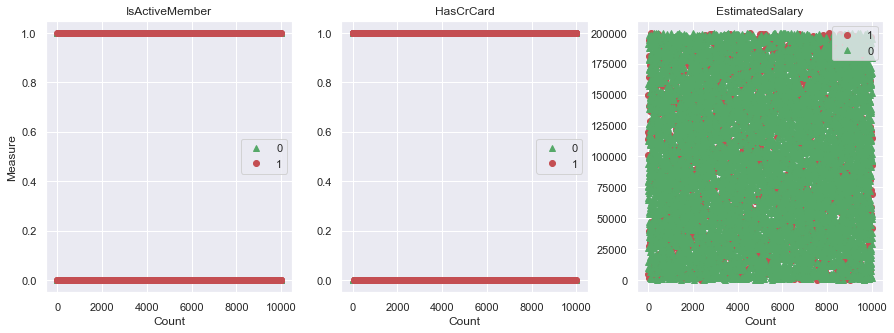

In [8]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

att1, att2, att3 = np.random.choice(data.columns.delete([13]), 3, replace=False)

att1_data = list(data[att1].groupby(data['Exited']))
ax1.plot(att1_data[0][1], 'g^', label=att1_data[0][0])
ax1.plot(att1_data[1][1], 'ro', label=att1_data[1][0])
ax1.set_xlabel('Count'); ax1.set_ylabel('Measure'); ax1.set_title(att1_data[0][1].name)
ax1.legend()

att2_data = list(data[att2].groupby(data['Exited']))
ax2.plot(att2_data[0][1], 'g^', label=att2_data[0][0])
ax2.plot(att2_data[1][1], 'ro', label=att2_data[1][0])
ax2.set_xlabel('Count'); ax2.set_ylabel(''); ax2.set_title(att2_data[0][1].name)
ax2.legend()

att3_data = list(data[att3].groupby(data['Exited']))
ax3.plot(att3_data[1][1], 'ro', label=att3_data[1][0])
ax3.plot(att3_data[0][1], 'g^', label=att3_data[0][0])
ax3.set_xlabel('Count'); ax3.set_ylabel(''); ax3.set_title(att3_data[0][1].name)
ax3.legend(); plt.show()

It seems that our classes are not well separated. There are techniques to fight the class-imbalance problem but in this case we are just going to continue like this.

### One-Hot Encoding

Convert categorical data to numerical. We have two categorical features in our case: *geography* & *gender*

In [9]:
data = pd.get_dummies(data)
data.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0


### Feature correlation

We want the features to be independent of each-other. Most ML algorithms work on this assumption.


#### Correlation of features with the class label
This will also give us an impression into which variable is the more important for predicting the class variable.

None of the attributes seems to be significantly correlated with the class.

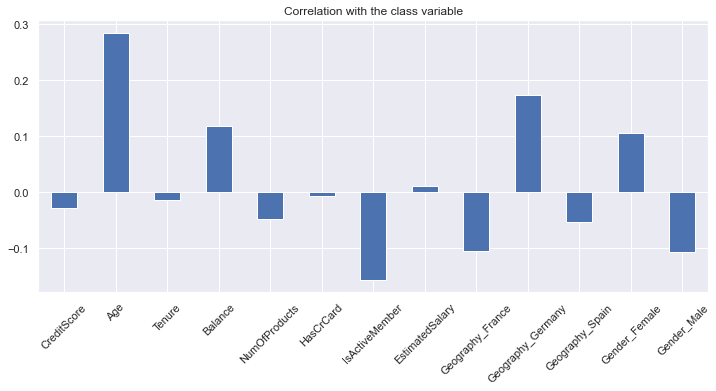

In [10]:
data.drop('Exited', axis=1).corrwith(data['Exited']).plot.bar(figsize=(12,5), 
                                            title='Correlation with the class variable', rot=45, fontsize=11)
plt.show()

We can also check the influence of the attributes on the class by aggregating the mean values after grouping by the class label. The below result confirms the correlation plot above.

In [11]:
class_group = data.groupby('Exited')
print(class_group.agg(np.mean))

        CreditScore        Age    Tenure       Balance  NumOfProducts  \
Exited                                                                  
0        651.853196  37.408389  5.033279  72745.296779       1.544267   
1        645.351497  44.837997  4.932744  91108.539337       1.475209   

        HasCrCard  IsActiveMember  EstimatedSalary  Geography_France  \
Exited                                                                 
0        0.707146        0.554565     99738.391772          0.527942   
1        0.699067        0.360825    101465.677531          0.397644   

        Geography_Germany  Geography_Spain  Gender_Female  Gender_Male  
Exited                                                                  
0                0.212859         0.259199       0.427477     0.572523  
1                0.399607         0.202749       0.559156     0.440844  


#### Correlation of features with each-other

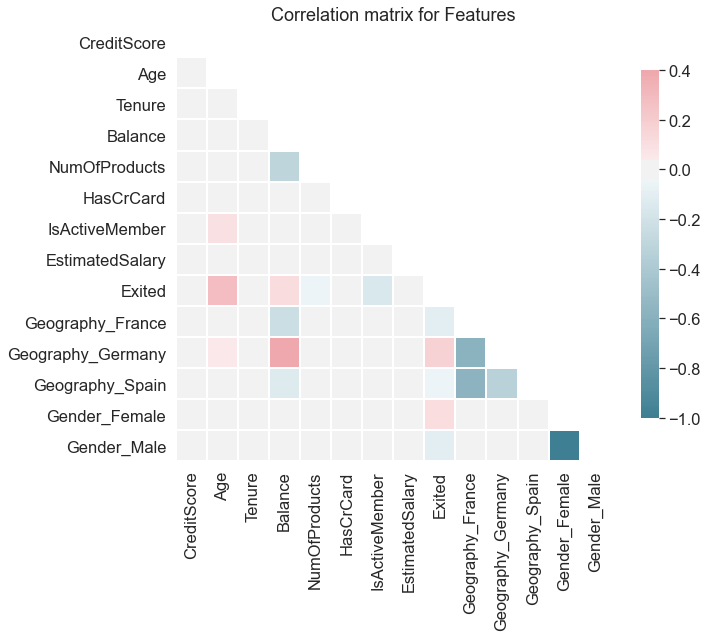

In [12]:
sns.set(style='white', font_scale=1.5)
corr_matrix = data.corr()

# create a mask for the upper triangle so that we can ignore it when later building the heatmap
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# color map for the different values of the correlation matrix
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(11,8))
plt.title('Correlation matrix for Features')
sns.heatmap(corr_matrix, square=True, mask=mask, cmap=cmap, center=0, linewidths=1.0, cbar_kws={'shrink':0.8})
plt.show()

We can see some correlations, like for instance the negative correlation between the number of products and the balance but they are less than 0.3 and so do not pose any problems for the algorithm. We may further proceed like this.

## Prepare the data for the Neural Net Model

1. Class & Features separation
2. Train/Test split
3. Scaling/Standardization if needed

### Class & Feature separation

In [13]:
labels = data.pop('Exited')
features = data
print('Shape of features', features.shape)
print('Shape of labels', labels.shape)
features.head(2)

Shape of features (10000, 13)
Shape of labels (10000,)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,1,0


### Train/Test split

In [14]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, 
                                                                            random_state=1, stratify=labels)
print('Shape of training data', train_features.shape)
print('Shape of testing data', test_features.shape)

Shape of training data (7000, 13)
Shape of testing data (3000, 13)


### Feature Scaling

In [15]:
scaler = StandardScaler()
to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

train_features_sc = pd.DataFrame(scaler.fit_transform(train_features[to_scale]))
train_features_sc.columns = train_features[to_scale].columns
train_features_sc.index = train_features[to_scale].index.values
train_features[to_scale] = train_features_sc

test_features_sc = pd.DataFrame(scaler.fit_transform(test_features[to_scale]))
test_features_sc.columns = test_features[to_scale].columns
test_features_sc.index = test_features[to_scale].index.values
test_features[to_scale] = test_features_sc

## Build & train the Neural Net model

We shall first build a basic Neural Net model using Keras. On the next chapter we shall see how to tune its parameters using talos in a bid to improve the model's performance.

### Build the Deep Neural Net

We can instantiate different aspects of the neural net either by passing a string identifier (and in this case the default parameters for the optimizer can be used) or by building an object from the class. The latter should be the used way as it gives us the possibility to tweak stuff.

[Docs](https://keras.io/api/layers/core_layers/dense/) on the dense layers

[Docs](https://keras.io/api/models/model_training_apis/) for the compile method

[Docs](https://keras.io/api/optimizers/) on optimizers

[Docs](https://keras.io/api/losses/) on the loss function
- *from_logits=True*: will significantly boost testing accuracy at a cost of training
- *label_smoothing=1*: can be played with in the range of [0,1]
- *reduction*: different options include, 'sum', keras.losses.Reduction.NONE

[Docs](https://keras.io/api/models/model_training_apis/) on the fit method

1. *class_weight*: can be useful to tell the model to "pay more attention" to samples from an under-represented class

In [16]:
ann = Sequential()
ann.add(Dense(units=100, activation='relu', use_bias=True))
ann.add(Dense(units=64, activation='relu', use_bias=True))
ann.add(Dense(units=32, activation='relu', use_bias=True))
ann.add(Dense(units=32, activation='relu', use_bias=True))

# Use sigmoid in the final layer since we have a binary classification problem
ann.add(Dense(units=1, activation='sigmoid', use_bias=False))

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# binary cross entropy as loss since we have a binary classification problem
loss = keras.losses.BinaryCrossentropy(name='binary_crossentropy', from_logits=False,
                                                                            label_smoothing=0.05, reduction='auto')

ann.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [17]:
def get_class_weights(labels):
    counter = Counter(labels)
    majority = max(counter.values())
    return {cls: float(majority/count) for cls, count in counter.items()}

In [18]:
c_weight = {0:1, 1:4}
ann.fit(x=train_features.values, y=train_labels.values, epochs=100, verbose=2, shuffle=True, batch_size=70,
                 use_multiprocessing=True, )

Epoch 1/100
 - 0s - loss: 0.4943 - accuracy: 0.7957
Epoch 2/100
 - 0s - loss: 0.4509 - accuracy: 0.8199
Epoch 3/100
 - 0s - loss: 0.4327 - accuracy: 0.8319
Epoch 4/100
 - 0s - loss: 0.4137 - accuracy: 0.8451
Epoch 5/100
 - 0s - loss: 0.3913 - accuracy: 0.8564
Epoch 6/100
 - 0s - loss: 0.3835 - accuracy: 0.8594
Epoch 7/100
 - 0s - loss: 0.3798 - accuracy: 0.8631
Epoch 8/100
 - 0s - loss: 0.3745 - accuracy: 0.8644
Epoch 9/100
 - 0s - loss: 0.3718 - accuracy: 0.8680
Epoch 10/100
 - 0s - loss: 0.3694 - accuracy: 0.8684
Epoch 11/100
 - 0s - loss: 0.3673 - accuracy: 0.8706
Epoch 12/100
 - 0s - loss: 0.3657 - accuracy: 0.8706
Epoch 13/100
 - 0s - loss: 0.3638 - accuracy: 0.8707
Epoch 14/100
 - 0s - loss: 0.3618 - accuracy: 0.8726
Epoch 15/100
 - 0s - loss: 0.3603 - accuracy: 0.8743
Epoch 16/100
 - 0s - loss: 0.3574 - accuracy: 0.8750
Epoch 17/100
 - 0s - loss: 0.3544 - accuracy: 0.8750
Epoch 18/100
 - 0s - loss: 0.3550 - accuracy: 0.8744
Epoch 19/100
 - 0s - loss: 0.3510 - accuracy: 0.8784
Ep

## Test the Model

In [19]:
print('Shape of testing dataset', test_features.shape)
predictions = ((ann.predict(test_features, batch_size=70)) > 0.5)
print('Our models accuracy on test data: ', round(100*accuracy_score(test_labels, predictions), 2))

Shape of testing dataset (3000, 13)
Our models accuracy on test data:  83.87


## Interpret the Model

Our Deep Neural Network performed good. It achieved an ~83% accuracy on the testing data. This was achieved only by utilizing a few hyperparameters of the neural network.

We shall next see if we can improve this number by tuning the various hyperparameters that a neural network can take. We shall do this using talos.